In [1]:
# Run this First BTW
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [2]:

from google.colab import drive
drive.mount ('/content/drive')
zip_path = '/content/drive/MyDrive/Capstone_Dataset/Potholes_4.zip'
data_dir = '/tmp/pothole_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
source_path = '/tmp/pothole_dataset/'

source_path_normal = os.path.join(source_path, 'Normal')
source_path_pothole = os.path.join(source_path, 'Holes')

print(f"There are {len(os.listdir(source_path_normal))} images of normal.")
print(f"There are {len(os.listdir(source_path_pothole))} images of pothole.")

There are 2283 images of normal.
There are 2006 images of pothole.


In [4]:
root_dir = '/tmp/normal-v-holes'

if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(root_path):
 
  os.makedirs(os.path.join(root_path, 'training', 'Normal'))
  os.makedirs(os.path.join(root_path, 'training', 'Holes'))
  os.makedirs(os.path.join(root_path, 'validation', 'Normal'))
  os.makedirs(os.path.join(root_path, 'validation', 'Holes'))

  pass  
  
try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [5]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/normal-v-holes/training
/tmp/normal-v-holes/validation
/tmp/normal-v-holes/training/Normal
/tmp/normal-v-holes/training/Holes
/tmp/normal-v-holes/validation/Normal
/tmp/normal-v-holes/validation/Holes


In [6]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE_DIR):
    file = SOURCE_DIR + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")
  
  # Shuffle the files
  random.shuffle(files)

  # Split the files into training and validation sets
  split_idx = int(len(files) * SPLIT_SIZE)
  train_files = files[:split_idx]
  validation_files = files[split_idx:]
  
  # Copy the files into the appropriate directories
  for filename in train_files:
    this_file = SOURCE_DIR + filename
    destination = TRAINING_DIR + filename
    shutil.copyfile(this_file, destination)
    
  for filename in validation_files:
    this_file = SOURCE_DIR + filename
    destination = VALIDATION_DIR + filename
    shutil.copyfile(this_file, destination)
  pass


  

In [7]:
NORMAL_SOURCE_DIR = '/tmp/pothole_dataset/Normal/'
POTHOLES_SOURCE_DIR = '/tmp/pothole_dataset/Holes/'

TRAINING_DIR = "/tmp/normal-v-holes/training/"
VALIDATION_DIR = "/tmp/normal-v-holes/validation/"

TRAINING_NORMAL_DIR = os.path.join(TRAINING_DIR, "Normal/")
VALIDATION_NORMAL_DIR = os.path.join(VALIDATION_DIR, "Normal/")

TRAINING_HOLES_DIR = os.path.join(TRAINING_DIR, "Holes/")
VALIDATION_HOLES_DIR = os.path.join(VALIDATION_DIR, "Holes/")

In [8]:
if len(os.listdir(TRAINING_NORMAL_DIR)) > 0:
  for file in os.scandir(TRAINING_NORMAL_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_HOLES_DIR)) > 0:
  for file in os.scandir(TRAINING_HOLES_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_NORMAL_DIR)) > 0:
  for file in os.scandir(VALIDATION_NORMAL_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_HOLES_DIR)) > 0:
  for file in os.scandir(VALIDATION_HOLES_DIR):
    os.remove(file.path)


In [9]:
split_size = .9

split_data(NORMAL_SOURCE_DIR, TRAINING_NORMAL_DIR, VALIDATION_NORMAL_DIR, split_size)
split_data(POTHOLES_SOURCE_DIR, TRAINING_HOLES_DIR, VALIDATION_HOLES_DIR, split_size)


In [10]:
# Show the image are in path
print(f"There are {len(os.listdir(TRAINING_NORMAL_DIR))} images of normal for training")
print(f"There are {len(os.listdir(TRAINING_HOLES_DIR))} images of holes for training")
print(f"There are {len(os.listdir(VALIDATION_NORMAL_DIR))} images of normal for validation")
print(f"There are {len(os.listdir(VALIDATION_HOLES_DIR))} images of holes for validation")

There are 2054 images of normal for training
There are 1805 images of holes for training
There are 229 images of normal for validation
There are 201 images of holes for validation


In [11]:
def preprocess_image(image):
    # Konversi ke grayscale
    gray = tf.image.rgb_to_grayscale(image)
    
    # Normalisasi nilai piksel
    normalized = gray / 255.0
    
    return normalized

In [12]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Data augmentation
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Add Features to Edge 

  train_generator = ImageDataGenerator(preprocessing_function=preprocess_image).flow_from_directory(directory=TRAINING_DIR,
                                                                                                     batch_size=30,
                                                                                                     class_mode='binary',
                                                                                                     target_size=(300, 300))
  validation_datagen = ImageDataGenerator(rescale=1./255)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=30,
                                                                class_mode='binary',
                                                                target_size=(300, 300))
  return train_generator, validation_generator

In [13]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 3549 images belonging to 2 classes.
Found 398 images belonging to 2 classes.


In [14]:
def create_model():

  model = tf.keras.models.Sequential([  
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(300,300,3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0008),
                loss='binary_crossentropy',
                metrics=['accuracy'])
    
  return model

In [15]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 128)      0

In [16]:
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
119/119 [==============================] - 116s 919ms/step - loss: 0.4356 - accuracy: 0.7977 - val_loss: 0.3961 - val_accuracy: 0.8266
Epoch 2/15
119/119 [==============================] - 109s 921ms/step - loss: 0.2381 - accuracy: 0.9121 - val_loss: 0.2822 - val_accuracy: 0.9045
Epoch 3/15
119/119 [==============================] - 110s 924ms/step - loss: 0.2108 - accuracy: 0.9203 - val_loss: 0.3705 - val_accuracy: 0.8945
Epoch 4/15
119/119 [==============================] - 107s 888ms/step - loss: 0.1714 - accuracy: 0.9400 - val_loss: 0.2887 - val_accuracy: 0.9070
Epoch 5/15
119/119 [==============================] - 108s 908ms/step - loss: 0.1402 - accuracy: 0.9470 - val_loss: 0.2511 - val_accuracy: 0.9020
Epoch 6/15
119/119 [==============================] - 112s 929ms/step - loss: 0.1069 - accuracy: 0.9586 - val_loss: 0.2666 - val_accuracy: 0.9045
Epoch 7/15
119/119 [==============================] - 112s 946ms/step - loss: 0.0728 - accuracy: 0.9755 - val_loss: 0.2975 -

Text(0.5, 1.0, 'Training and validation loss')

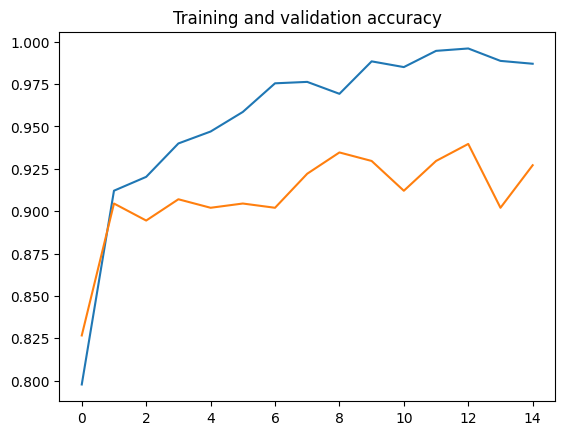

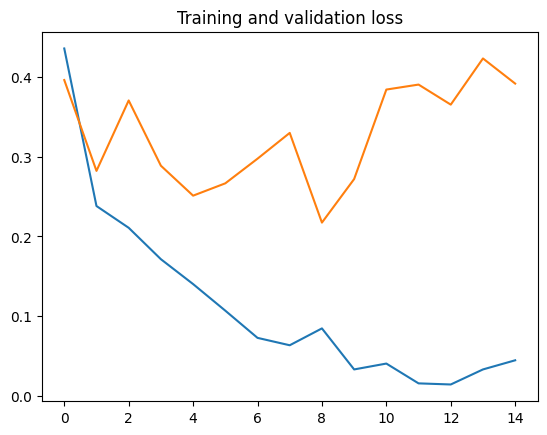

In [17]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

plt.plot  ( epochs,     acc )

plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [18]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(300, 300))
  
  x=img_to_array(img)
  x /= 255
  x= np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=20)
  
  print(classes[0])
  
  if classes[0]>0.5:
    print(fn + " is a normal")
  else:
    print(fn + " is a pothole")
 

KeyboardInterrupt: ignored

In [21]:
model.save("modelteraakhir.h5")